# PerkinElmer Reflectance Code
Code to read reflectance data exported as .csv from the Perkin Elmer Lambda 750 UV/Vis/NIR Absorption Spectrometer and apply calibration using the Zenith Polymer Diffuse Reflectance Standards.

In [1]:
# import modules
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib import rcParams
import matplotlib.cm as cm
import math
import numpy as np
import pandas as pd
import os
from scipy import interpolate

%matplotlib inline

# specify sample data, export and calibration folders
sample_folder = r'C:\Users\tl457\OneDrive - University Of Cambridge 1\1_Data\McMaster-Feb22-Samples\220207_McMasterFeb_Ref'
export_folder = r'C:\Users\tl457\OneDrive - University Of Cambridge 1\1_Data\McMaster-Feb22-Samples\220207_McMasterFeb_Ref'
calibration_folder = r'C:\Users\tl457\OneDrive - University Of Cambridge 1\6_Reference_Material\Equipment\Zenith Polymer Diffuse Reflectance Standards'

# specify matplotlib configuration file path
rc_fname = r'C:\Users\tl457\Documents\GitHub\spectroscopy\plotting_params.txt'

In [2]:
# display sample names
sample_names=pd.read_csv(os.path.join(sample_folder,"Results Table.csv"),index_col=0,usecols=[0])
sample_names.style
for i in sample_names.index:
    sample_names.loc[i,'File']=os.path.join(sample_folder,i+'.Sample.Raw.csv')

# create DataFrame
data=pd.DataFrame()
for i in sample_names.index:
    temp=pd.read_csv(sample_names.loc[i,'File'],index_col=0)
    data[i]=np.concatenate(temp.values).ravel()
data.index=temp.index

# create list of colours for plots from list of samples
evenly_spaced_interval = np.linspace(0, 1, len(sample_names.index))
colors = [cm.magma(x) for x in evenly_spaced_interval]

# list sample names and .csv file locations
sample_names.style

,File
Sample ID,
2.5% DR Standard,C:\Users\tl457\OneDrive - University Of Cambridge 1\1_Data\McMaster-Feb22-Samples\220207_McMasterFeb_Ref\2.5% DR Standard.Sample.Raw.csv
99% DR Standard,C:\Users\tl457\OneDrive - University Of Cambridge 1\1_Data\McMaster-Feb22-Samples\220207_McMasterFeb_Ref\99% DR Standard.Sample.Raw.csv
Sample1,C:\Users\tl457\OneDrive - University Of Cambridge 1\1_Data\McMaster-Feb22-Samples\220207_McMasterFeb_Ref\Sample1.Sample.Raw.csv
Sample2,C:\Users\tl457\OneDrive - University Of Cambridge 1\1_Data\McMaster-Feb22-Samples\220207_McMasterFeb_Ref\Sample2.Sample.Raw.csv


In [3]:
# load calibration files
dark_ref=pd.read_csv(os.path.join(calibration_folder,"22011925.csv"),sep=';',skiprows=1,index_col=0,decimal=',')
white_ref=pd.read_csv(os.path.join(calibration_folder,"22011924.csv"),sep=';',skiprows=1,index_col=0,decimal=',')

# create interpolated functions from manufacturer calibration data
dark_array=(dark_ref.index,dark_ref.values)
white_array=(white_ref.index,white_ref.values)
dark_func=interpolate.interp1d(dark_array[0],dark_array[1].ravel())
white_func=interpolate.interp1d(white_array[0],white_array[1].ravel())

# create y = mx+c calibration functions from experimental and manufacturer calibration data
calib=pd.DataFrame()
for i in data.index:
    dark_data=data['2.5% DR Standard']
    white_data=data['99% DR Standard']
    m=(white_func(i)-dark_func(i))/(white_data[i]-dark_data[i])
    c=white_func(i)-(m*(white_data[i]))
    calib[i]=(m,c)

# apply calibration and create a new DataFrame with the corrected data
data_processed=pd.DataFrame()
for i in sample_names.index:
    r_arr=[]
    for j in data.index:
        temp=data[i]
        new_r=(calib[j][0]*temp[j])+calib[j][1]
        r_arr.append(new_r)
    data_processed[i]=r_arr
data_processed.index=data.index

print(' y=mx+c calibration functions consist of two parameters [0]=gradient and [1]=y-intercept at each wavelength')
calib.style

 y=mx+c calibration functions consist of two parameters [0]=gradient and [1]=y-intercept at each wavelength


,800.0,799.0,798.0,797.0,796.0,795.0,794.0,793.0,792.0,791.0,790.0,789.0,788.0,787.0,786.0,785.0,784.0,783.0,782.0,781.0,780.0,779.0,778.0,777.0,776.0,775.0,774.0,773.0,772.0,771.0,770.0,769.0,768.0,767.0,766.0,765.0,764.0,763.0,762.0,761.0,760.0,759.0,758.0,757.0,756.0,755.0,754.0,753.0,752.0,751.0,750.0,749.0,748.0,747.0,746.0,745.0,744.0,743.0,742.0,741.0,740.0,739.0,738.0,737.0,736.0,735.0,734.0,733.0,732.0,731.0,730.0,729.0,728.0,727.0,726.0,725.0,724.0,723.0,722.0,721.0,720.0,719.0,718.0,717.0,716.0,715.0,714.0,713.0,712.0,711.0,710.0,709.0,708.0,707.0,706.0,705.0,704.0,703.0,702.0,701.0,700.0,699.0,698.0,697.0,696.0,695.0,694.0,693.0,692.0,691.0,690.0,689.0,688.0,687.0,686.0,685.0,684.0,683.0,682.0,681.0,680.0,679.0,678.0,677.0,676.0,675.0,674.0,673.0,672.0,671.0,670.0,669.0,668.0,667.0,666.0,665.0,664.0,663.0,662.0,661.0,660.0,659.0,658.0,657.0,656.0,655.0,654.0,653.0,652.0,651.0,650.0,649.0,648.0,647.0,646.0,645.0,644.0,643.0,642.0,641.0,640.0,639.0,638.0,637.0,636.0,635.0,634.0,633.0,632.0,631.0,630.0,629.0,628.0,627.0,626.0,625.0,624.0,623.0,622.0,621.0,620.0,619.0,618.0,617.0,616.0,615.0,614.0,613.0,612.0,611.0,610.0,609.0,608.0,607.0,606.0,605.0,604.0,603.0,602.0,601.0,600.0,599.0,598.0,597.0,596.0,595.0,594.0,593.0,592.0,591.0,590.0,589.0,588.0,587.0,586.0,585.0,584.0,583.0,582.0,581.0,580.0,579.0,578.0,577.0,576.0,575.0,574.0,573.0,572.0,571.0,570.0,569.0,568.0,567.0,566.0,565.0,564.0,563.0,562.0,561.0,560.0,559.0,558.0,557.0,556.0,555.0,554.0,553.0,552.0,551.0,550.0,549.0,548.0,547.0,546.0,545.0,544.0,543.0,542.0,541.0,540.0,539.0,538.0,537.0,536.0,535.0,534.0,533.0,532.0,531.0,530.0,529.0,528.0,527.0,526.0,525.0,524.0,523.0,522.0,521.0,520.0,519.0,518.0,517.0,516.0,515.0,514.0,513.0,512.0,511.0,510.0,509.0,508.0,507.0,506.0,505.0,504.0,503.0,502.0,501.0,500.0,499.0,498.0,497.0,496.0,495.0,494.0,493.0,492.0,491.0,490.0,489.0,488.0,487.0,486.0,485.0,484.0,483.0,482.0,481.0,480.0,479.0,478.0,477.0,476.0,475.0,474.0,473.0,472.0,471.0,470.0,469.0,468.0,467.0,466.0,465.0,464.0,463.0,462.0,461.0,460.0,459.0,458.0,457.0,456.0,455.0,454.0,453.0,452.0,451.0,450.0,449.0,448.0,447.0,446.0,445.0,444.0,443.0,442.0,441.0,440.0,439.0,438.0,437.0,436.0,435.0,434.0,433.0,432.0,431.0,430.0,429.0,428.0,427.0,426.0,425.0,424.0,423.0,422.0,421.0,420.0,419.0,418.0,417.0,416.0,415.0,414.0,413.0,412.0,411.0,410.0,409.0,408.0,407.0,406.0,405.0,404.0,403.0,402.0,401.0,400.0,399.0,398.0,397.0,396.0,395.0,394.0,393.0,392.0,391.0,390.0,389.0,388.0,387.0,386.0,385.0,384.0,383.0,382.0,381.0,380.0,379.0,378.0,377.0,376.0,375.0,374.0,373.0,372.0,371.0,370.0,369.0,368.0,367.0,366.0,365.0,364.0,363.0,362.0,361.0,360.0,359.0,358.0,357.0,356.0,355.0,354.0,353.0,352.0,351.0,350.0,349.0,348.0,347.0,346.0,345.0,344.0,343.0,342.0,341.0,340.0,339.0,338.0,337.0,336.0,335.0,334.0,333.0,332.0,331.0,330.0,329.0,328.0,327.0,326.0,325.0,324.0,323.0,322.0,321.0,320.0,319.0,318.0,317.0,316.0,315.0,314.0,313.0,312.0,311.0,310.0,309.0,308.0,307.0,306.0,305.0,304.0,303.0,302.0,301.0,300.0
0,0.990745,0.990788,0.992649,0.990077,0.990881,0.991889,0.991954,0.991201,0.990447,0.990230,0.992461,0.989545,0.993165,0.989652,0.990432,0.988988,0.994136,0.990913,0.991531,0.989216,0.990976,0.991556,0.990455,0.992534,0.990620,0.990147,0.989445,0.990499,0.990279,0.988871,0.989466,0.989995,0.991785,0.992246,0.989547,0.991151,0.992640,0.990213,0.990107,0.992254,0.990910,0.990174,0.989724,0.991967,0.989235,0.991401,0.989518,0.989617,0.991184,0.989324,0.989862,0.991812,0.988048,0.991508,0.991574,0.990874,0.991380,0.991315,0.993338,0.992649,0.989656,0.989319,0.989692,0.992102,0.987649,0.990688,0.989745,0.990211,0.994409,0.990851,0.990673,0.989892,0.990267,0.991291,0.991152,0.991561,0.991196,0.991476,0.991253,0.991310,0.992079,0.990615,0.989886,0.990239,0.989800,0.989160,0.990591,0.990982,0.992194,0.990866,0.991594,0.991062,0.991438,0.991274,0.990759,0.991329,0.990990,0.990250,0.989775,0.989519,0.991255,0.990377,0.990862,0.989502,0.990124,0.989782,0.989512,0.990085,0.992304,0.991782,0

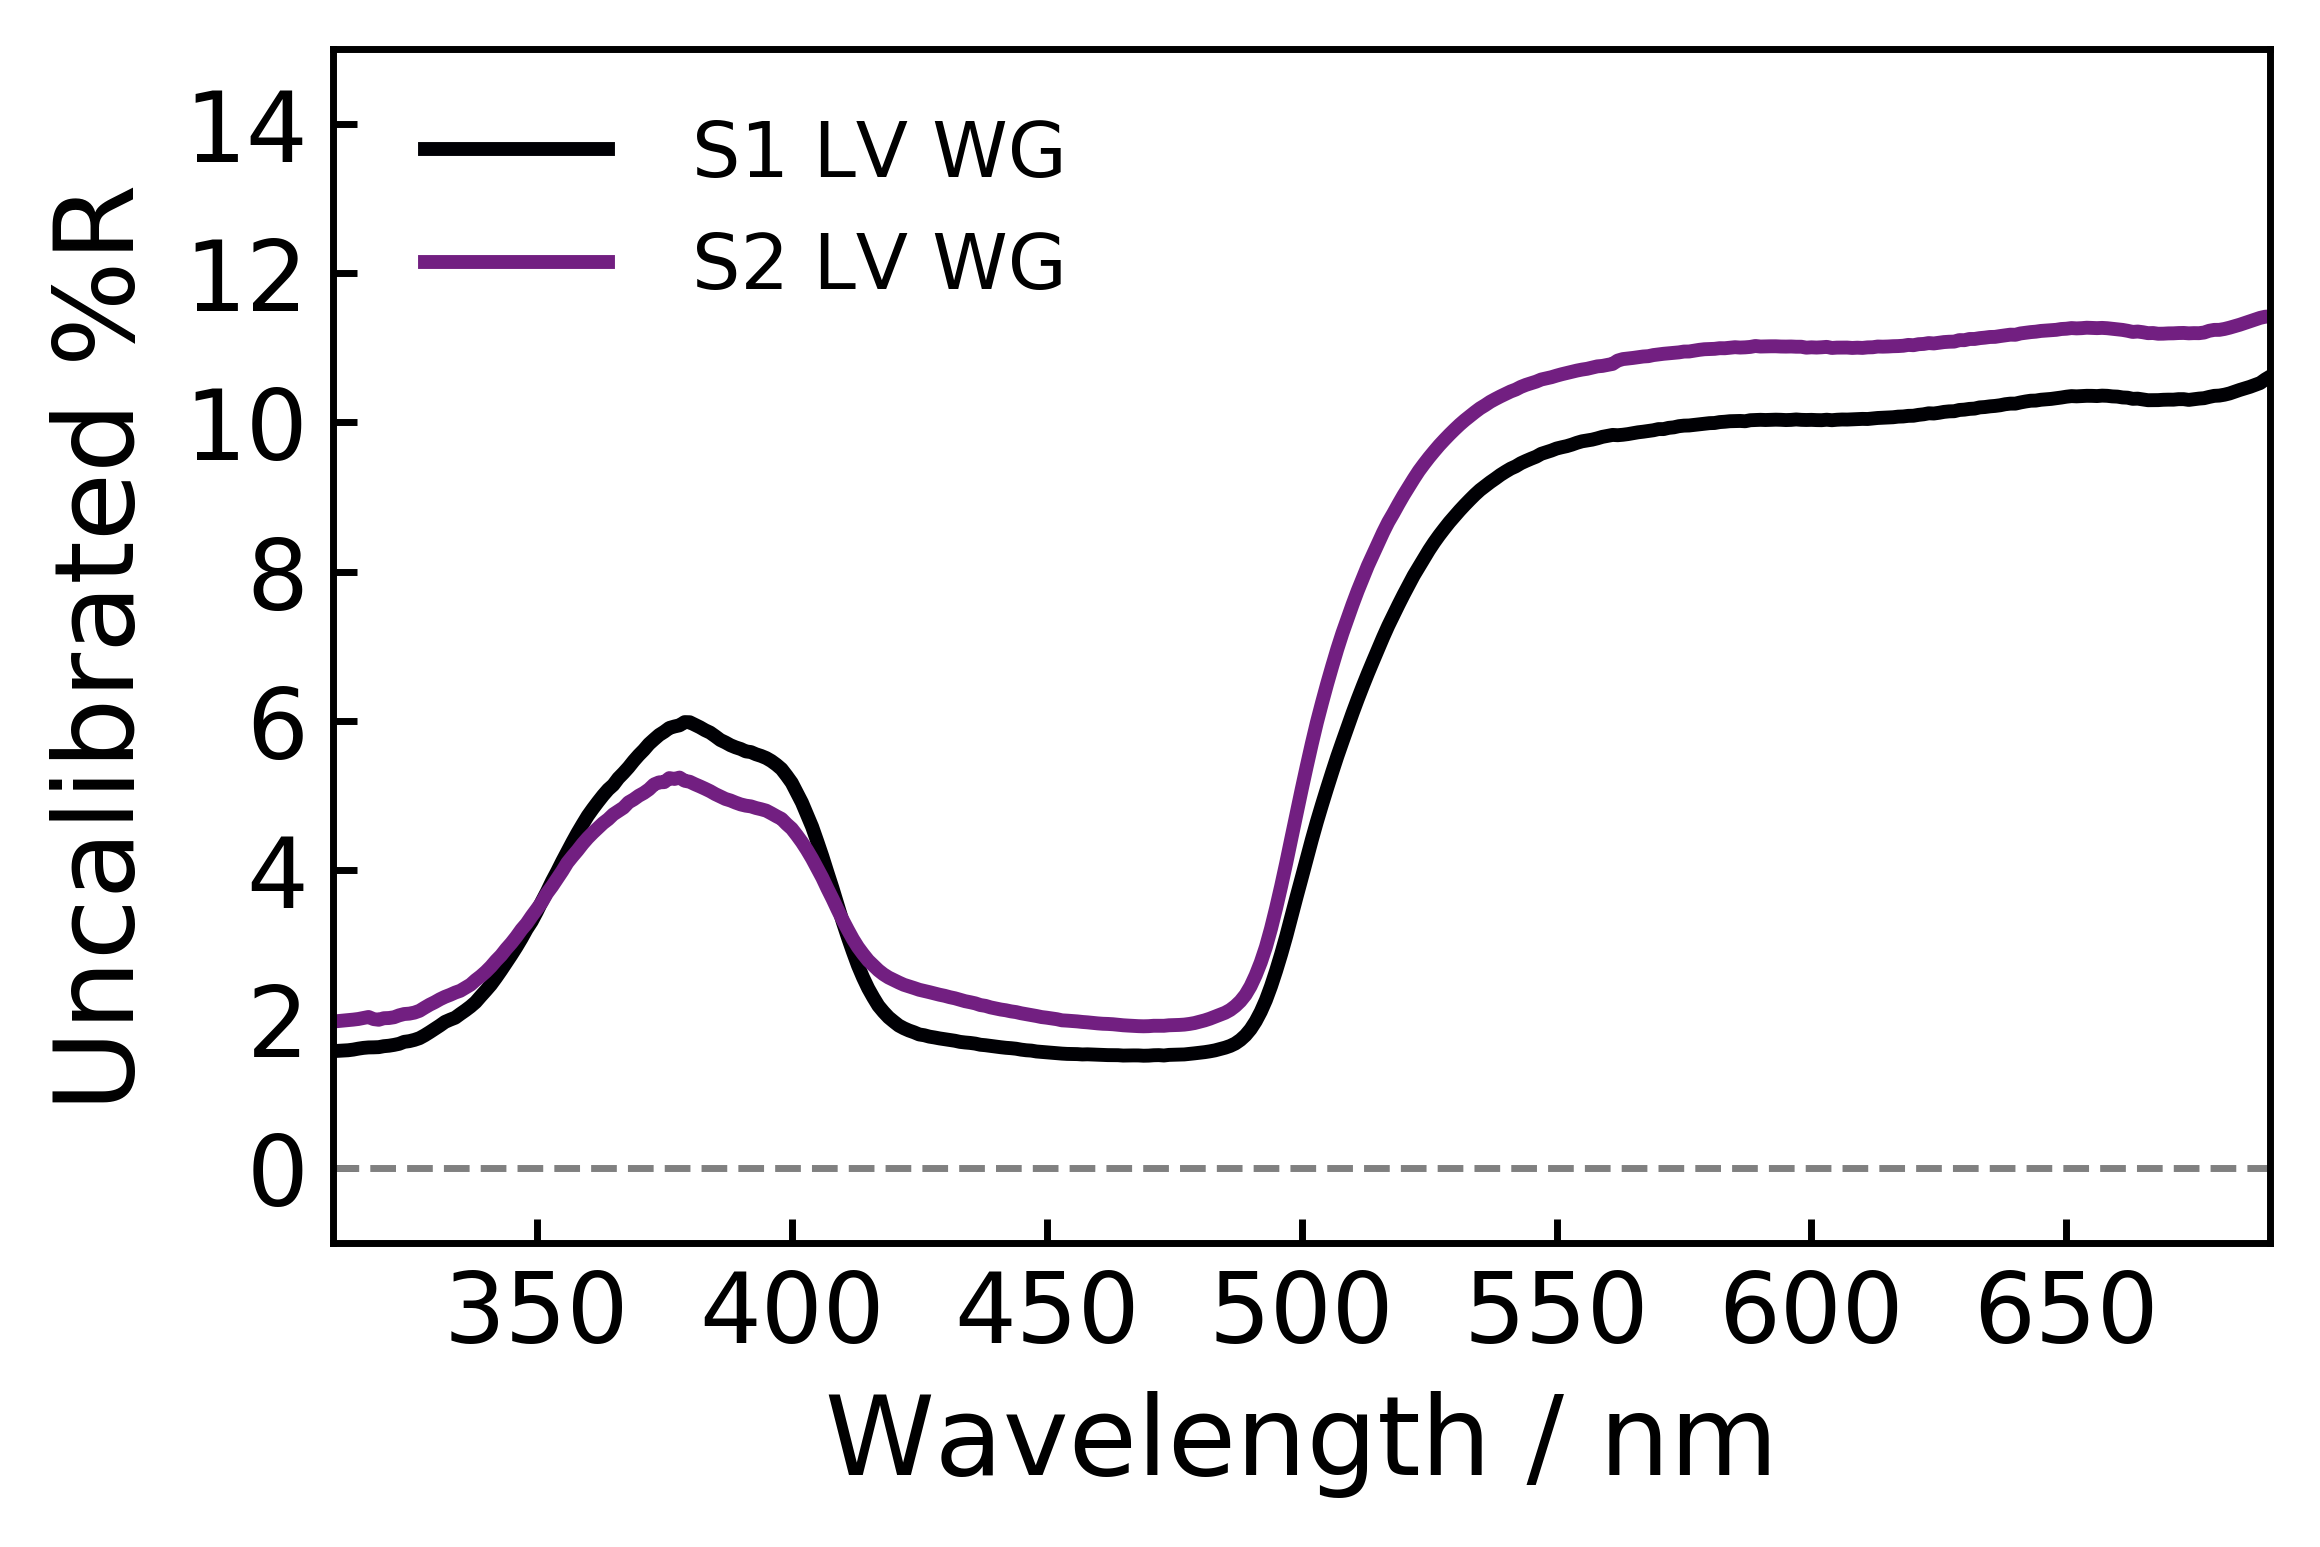

In [4]:
# plot uncalibrated reflectance
with rc_context(fname=rc_fname):
    plt.plot(data['Sample1'],label='S1 LV WG',color=colors[0])
    plt.plot(data['Sample2'],label='S2 LV WG',color=colors[1])
    plt.axhline(0,ls='--',color='grey',lw=1)
    plt.xlim(310,690)
    plt.ylim(-1,15)
    plt.xlabel('Wavelength / nm')
    plt.ylabel('Uncalibrated %R')
    plt.legend(fontsize=11,loc='upper left')

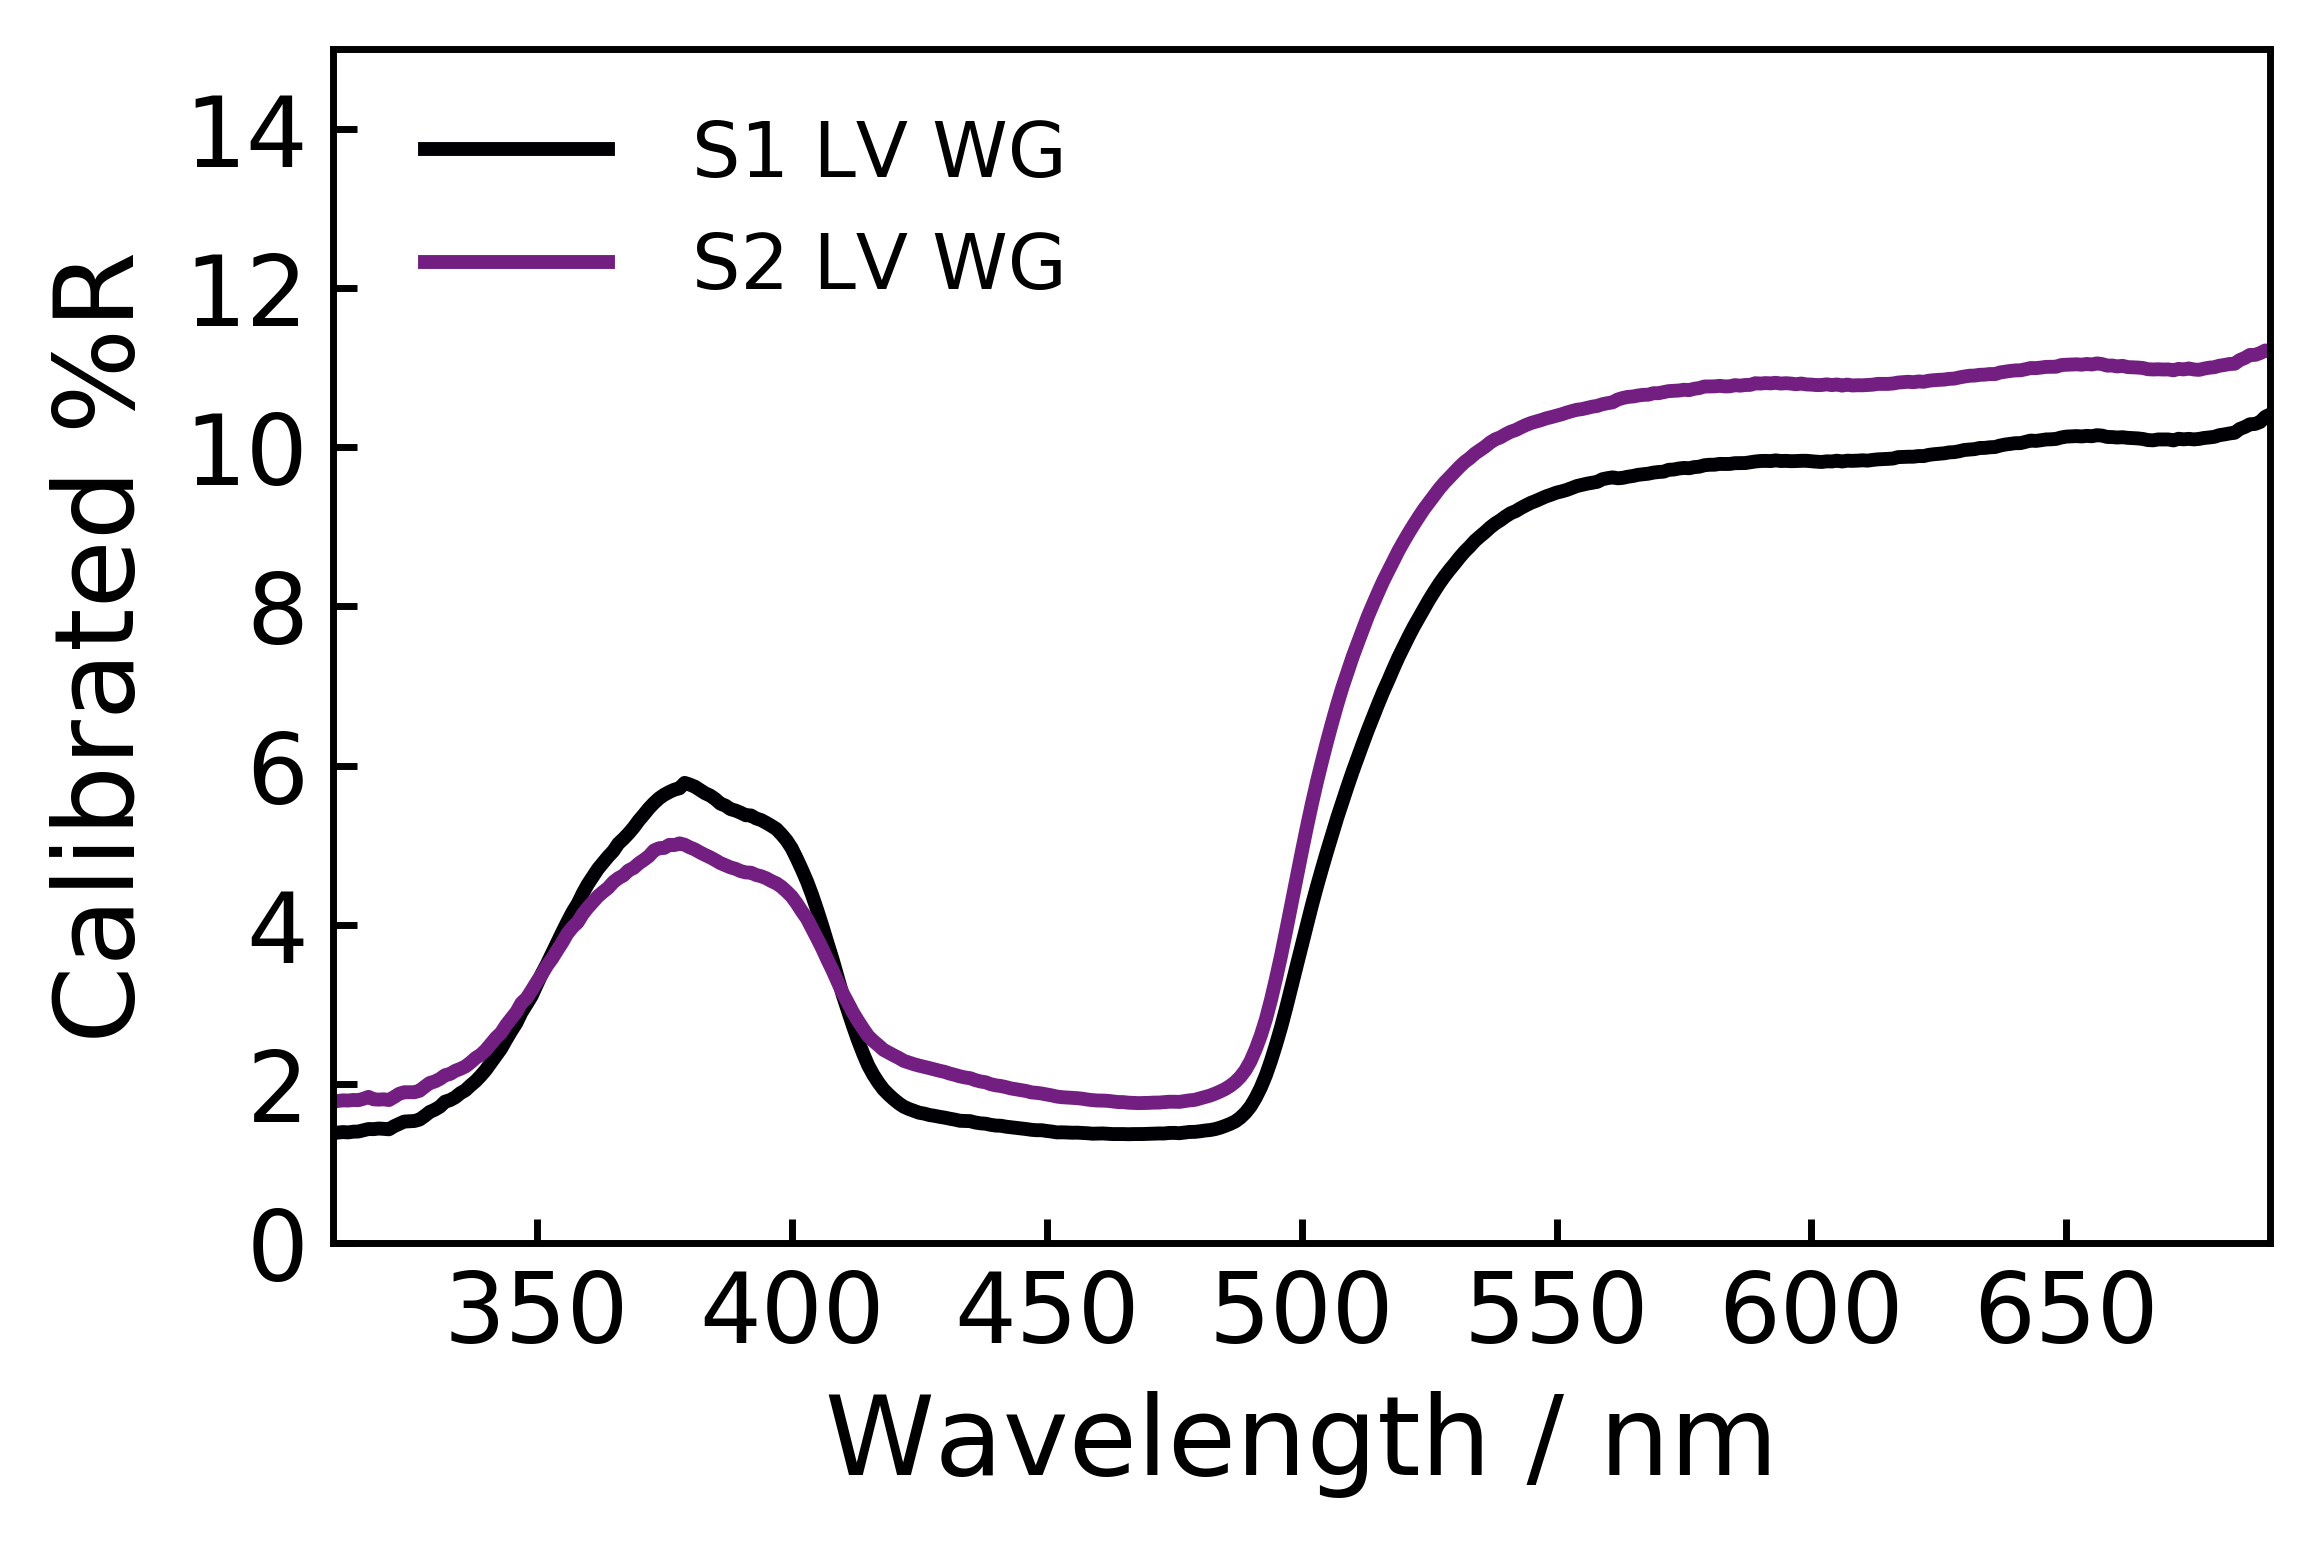

In [5]:
# plot calibrated reflectance
with rc_context(fname=rc_fname):
    plt.plot(data_processed['Sample1'],label='S1 LV WG',color=colors[0])
    plt.plot(data_processed['Sample2'],label='S2 LV WG',color=colors[1])
    plt.xlim(310,690)
    plt.ylim(0,15)
    plt.xlabel('Wavelength / nm')
    plt.ylabel('Calibrated %R')
    plt.legend(fontsize=11,loc='upper left')